<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/LabAssignmentRNNsToyTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing Sequences Using RNNs (and CNNs)

*Credits:* Based on code written by [A. Géron](https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb#scrollTo=AiINDLJHVNep) for his "Hands-on ML" book. Code realeased under MIT license.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In this activity we are going to explore different ways of modelling sequential data. We will try out simple baseline models as well as 1D CNNs and different RNNs to **forecast the next step in a time series**.

## Generating sample data

To experiment with different models, we'll use some randomly generated univariate time series.



In [2]:
def generate_time_series(batch_size, n_steps):
    # Pick random frequencies and time offsets for two sinusoidal curves
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    # First sine wave with 0.5 amplitude
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    # add second wave with 0.2 amplitude
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    # complete with some white noise (amplitude of 0.1, shift of -0.5 so it has mean=0)
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    # there goes our generate time series
    return series[..., np.newaxis].astype(np.float32)

In [12]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

Notice the shape of the series array:


In [4]:
series.shape

(10000, 51, 1)

The meaning of each dimension is `[samples, time steps, sequence element size]`.
Here each series element is a single scalar because we are making a univariate prediction.
If we were modeling mutiple time series at once (eg. temperature and humidity) this would be a multi-variate prediction and our sequence element size would be 2.

### Creating predicion targets
We want to predict one step further into the series. To do so , we can take the last time step of a series as the regression target, while using all the previous time steps as inputs.

We also want to split our data into train, validation and test sets as usual.

In [5]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

### Visualizing the data
This function plots the first series samples from a given batch, along with the next predicted value.

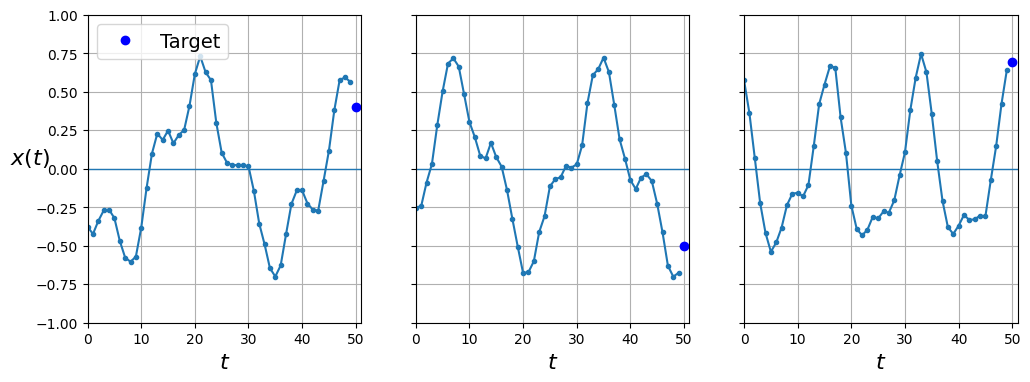

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

## Prediction task 1 : forecast one time step

We want to predict a single continuous value for each input sequence. This can be seen as a sequence-to-vector regression task. As seen in class, a suitable loss function is the `keras.losses.mean_squared_error` (as derived by MLE under a Gaussian assumption on the prediciton targets).


As we try out different models, keep the models and their validation performances. In the end you will compare their performances in validation to pick the best model (which will be applied to the test set).


### Simple baseline models

Before trying complex models, it is important to set up a baseline performance obtained with a simple model. This way we will only be interested in the more complex models if they do better than our baseline.

#### Baseline 1: Naive baseline

Our first baseline will follow a very simple rule: predict the series will not change. That means the output will be a repetition of the series value at the last observed time step.

This is very simple to implement: our predictions `y_pred` will simply be equal to the last time step in the `X` array.



##### TODO: write the naive baseline code bellow
Compute the naive predctions on the validation set and save them to a `y_pred` array.

In [10]:
#TODO
y_pred = y_valid[:len(y_test)-1]

Here is the first series in the validation set with its predicted value:

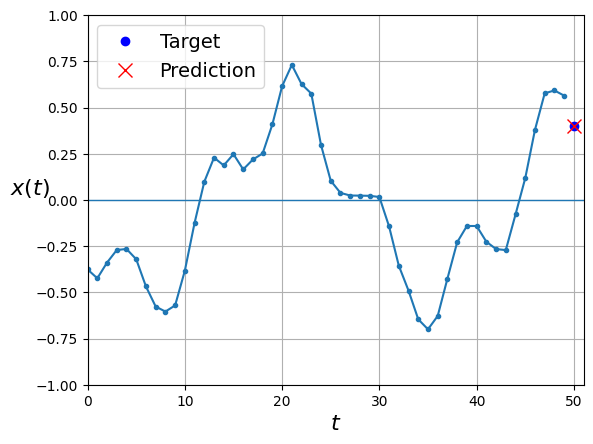

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

#### Baseline 2: linear baseline

Our second basline model will be a linear regression. We can implement it using keras `Sequential` API by simply using a `Dense` layer with no activation functions.



##### TODO: Declare and train the linear model
 - write a linear regression model using a Dense layer
 - Don't forget to use `Flatten` and define the expected input shape using the keyword argument `input_shape`
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set


In [55]:
np.random.seed(42)
tf.random.set_seed(42)

history = []
#TODO declare and train your model here
model = keras.Sequential([keras.layers.Flatten(input_shape=[n_steps,1]), keras.layers.Dense(units=1)])

model.compile(loss='mse', optimizer='adam')

history.append(model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid)))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2329 - val_loss: 0.0637
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0552 - val_loss: 0.0342
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0310 - val_loss: 0.0215
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0196 - val_loss: 0.0154
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - val_loss: 0.0125
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [21]:
# saving model stats for later
pred_one_models = {}
pred_one_models['linear']= {'model': model, 'history': history}

<Axes: >

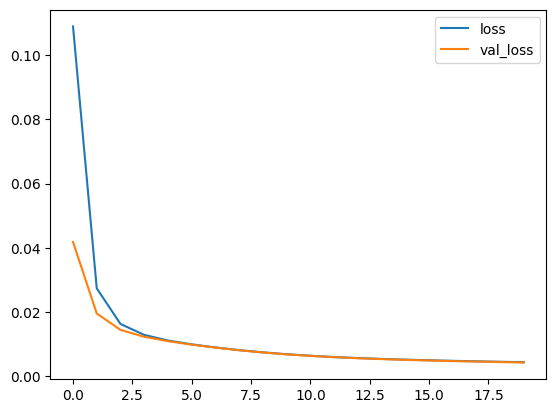

In [22]:
pd.DataFrame(history.history).plot()

In [58]:
grade=[]
grade.append(model.evaluate(X_valid, y_valid))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045


In [54]:
grade[1] = grade[0]
print(grade)

[0.010890108533203602, 0.010890108533203602, 0.0030095926485955715]


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


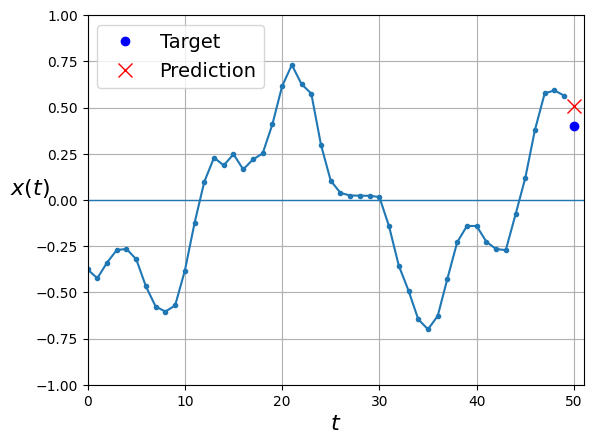

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

### Recurrent models

#### Model 1: Simple RNN
Our first recurrent model will use simple recurrent units. You can implement it using the built-in `keras.layers.SimpleRNN`.

Here again we will specify the expected input shape (ignoring the batch dimension). We want the time-steps dimension to be variable: thus we set it to `None`. The sequence element dimension continues to be 1.

##### TODO: train the simple RNN model
 - Use the Adam optimizer with the a learning rate of 0.02
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Input([None,1]),
    keras.layers.SimpleRNN(1)
])

#TODO train the model here
model.compile(loss='mse', optimizer='adam')

history.append(model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid)))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3173 - val_loss: 0.2170
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1909 - val_loss: 0.1056
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0904 - val_loss: 0.0528
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0488 - val_loss: 0.0395
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0383 - val_loss: 0.0354
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0345 - val_loss: 0.0324
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0317 - val_loss: 0.0298
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0292 - val_loss: 0.0275
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0270 - val_loss: 0.0254
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0251 - val_loss: 0.0236
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0233 - val_loss: 0.0220
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

In [33]:
# saving model stats for later
pred_one_models['simpleRNN']= {'model': model, 'history': history}

<Axes: >

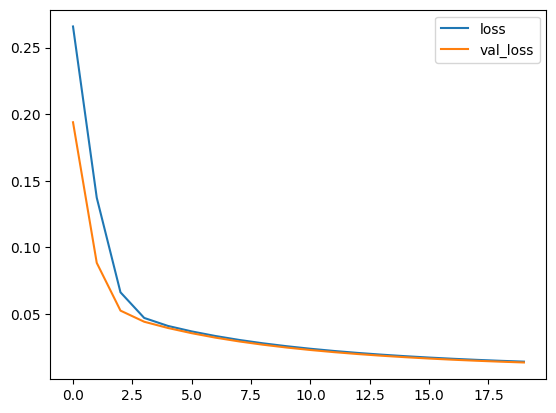

In [34]:
pd.DataFrame(history.history).plot()

In [60]:
grade.append(model.evaluate(X_valid, y_valid))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


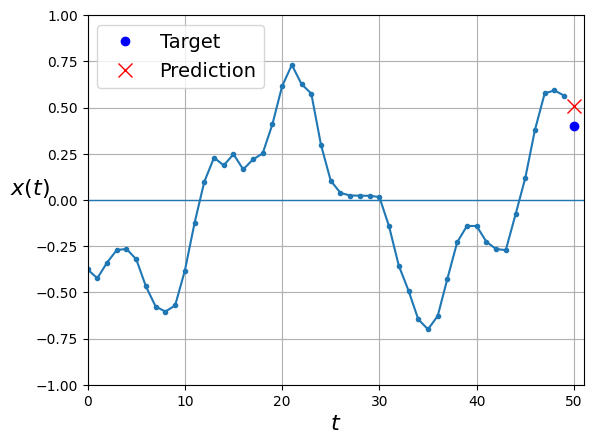

In [36]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Model 2: Deep simple RNN
This time we will use multiple recurrent layers in our model. The final output will be computed with a dense layer.


##### Chaining two RNN layers
Notice that while recurrent layers expect sequence inputs with 3 dimensions (samples, time, element size), they output by default 2 D data as in `[samples, predicted element size]`.

If you chain two RNN layers, the first one needs yield sequence-shaped outputs (with the 3 dimensions) so that it is compatible with the second layer. In this case, the layer needs to be declared with the keywork argument `return_sequences=True`.

##### TODO: Create and train a Deep RNN with 2 hidden recurrent layers
 - Use two simple RNN layers with 20 units
 - Compute the final output doing a linear read-out (use a Dense layer with no activation)
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

#TODO declare and train your model
model = keras.Sequential([keras.layers.Input([None,1]),
                          keras.layers.SimpleRNN(units=20),
                          keras.layers.Dense(units=1)])

model.compile(loss='mse', optimizer='adam')

history.append(model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid)))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0226 - val_loss: 0.0053
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
# saving model stats for later
pred_one_models['DeepRNN']= {'model': model, 'history': history}

<Axes: >

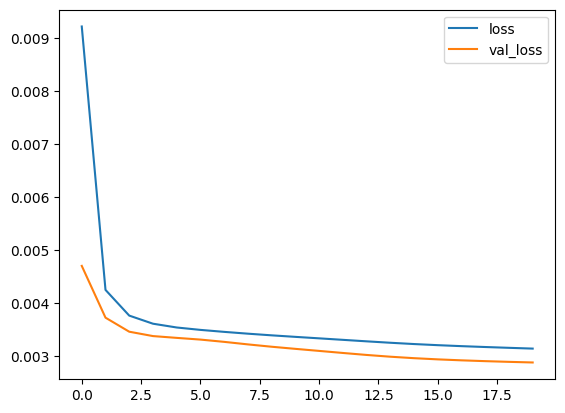

In [44]:
pd.DataFrame(history.history).plot()

In [62]:
grade.append(model.evaluate(X_valid, y_valid))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027


In [63]:
print(grade)

[0.004590555559843779, 0.013344455510377884, 0.002798705128952861]


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


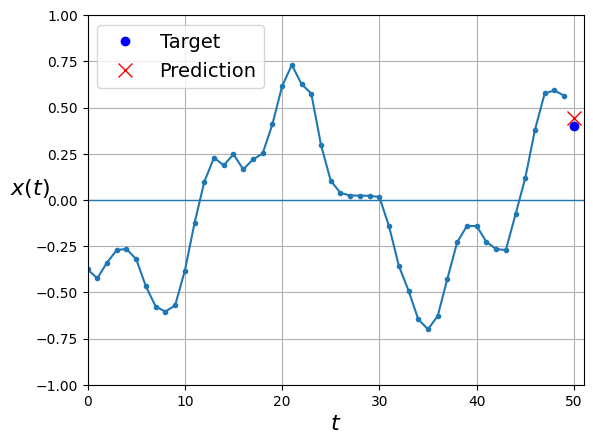

In [46]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

### TODO: Final comparison and model choice
Compare the compare performances of different models in validation to pick the best model.
Apply it to the test set and evaluate it: is the performance close to what you got in the validation set?

In [65]:
#TODO
print(grade)
print("We can observe than the best modèle is the third one with a loss value of 0.0028")

[0.004590555559843779, 0.013344455510377884, 0.002798705128952861]
We can observe than the best modèle is the third one with a loss value of 0.0028


In [66]:
pred_one_models

{'linear': {'model': <Sequential name=sequential_2, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7adc739469c0>},
 'DeepRNN': {'model': <Sequential name=sequential_4, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7adc7075bf20>},
 'simpleRNN': {'model': <Sequential name=sequential_3, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7adc58374fe0>}}

## Prediction task 2: forecast multiple time steps

This task can be formulated as a sequence-to-sequence task if we predict one output timstep at a time. But we can also formulate it as a sequence-to-vector task, in which we try to predict all time steps at once.

### Method 1: Predicting 1 step at a time (seq2seq)


We'll use the previous model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [67]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one. We will keep using the previous output as new input until we predict 10 values.

In [68]:
X = X_valid
model = pred_one_models['DeepRNN']['model']
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [69]:
Y_pred.shape

(2000, 10)

#### TODO: check the loss value (MSE) for this method

In [73]:
#TODO
model.compile(loss="mse", optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid))
model.evaluate(X_valid, y_valid)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1549 - val_loss: 0.0701
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0628 - val_loss: 0.0491
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0446 - val_loss: 0.0422
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0383 - val_loss: 0.0337
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0349 - val_loss: 0.0318
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0322 - val_loss: 0.0281
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0296 - val_loss: 0.0264
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0281 - val_loss: 0.0256
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0270 - val_loss: 0.0250
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0264 - val_loss: 0.0242
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0257 - val_loss: 0.0237
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

0.021241426467895508

#### Plot multiple forecasts
Use this plotting function to visualize your input series and the output predictions.

**Attention**: Reshape the outputs of your models acordingly:
If you model outputs 2D arrays with shape [batch size, time steps], you can use `Y[..., np.newaxis]` or `np.expand_dims(Y, shape=-1) ` to make them compatible with this function.

In [74]:
def plot_multiple_forecasts(X, Y, Y_pred):
    # X should be a rank 3 array with shapes [batch size, sequence length, 1]
    # Y and y_pred should also be rank 3 with shape [0, sequence lenght, 1]
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


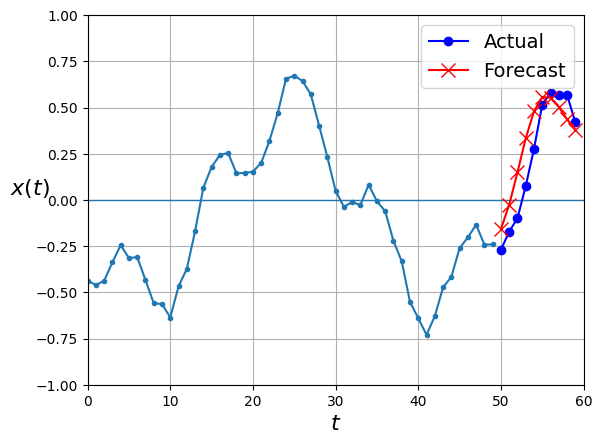

In [75]:
#Example
plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred[..., np.newaxis])

#### TODO: Baselines: naive and linear prediction

Implement the naive and the linear baselines folowing this method to predict the next 10 steps. Compare their performances to the previous RNN model.

### Method 2A: Predicting 10 steps at once at the end (seq2vec)

In this section we wil predict all 10 steps at once as a vector output at the end of the input sequence processing. Intermediate network outputs will be ignored.

In [76]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
val_loss =np.mean(keras.metrics.mse(Y_valid, Y_naive_pred))
val_loss

np.float32(0.25697407)

### Example with a Linear model

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Input([50, 1]),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2147 - val_loss: 0.0688
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0598 - val_loss: 0.0447
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0421 - val_loss: 0.0361
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0349 - val_loss: 0.0315
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0309 - val_loss: 0.0286
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0282 - val_loss: 0.0266
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - val_loss: 0.0252
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0249 - val_loss: 0.0241
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0239 - val_loss: 0.0232
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - val_loss: 0.0225
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0223 - val_loss: 0.0220
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [78]:
# saving model stats for later
pred_ten_models = {}
pred_ten_models['linear']= {'model': model, 'history': history}

<Axes: >

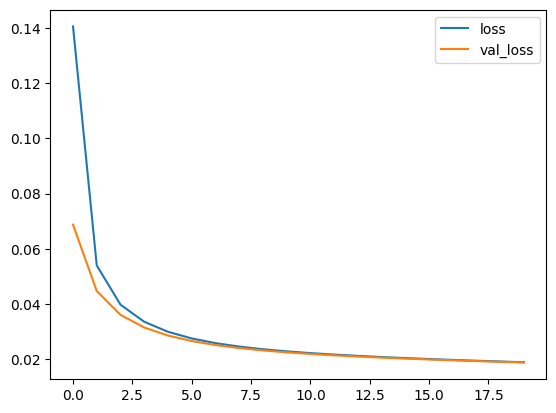

In [79]:
pd.DataFrame(history.history).plot()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


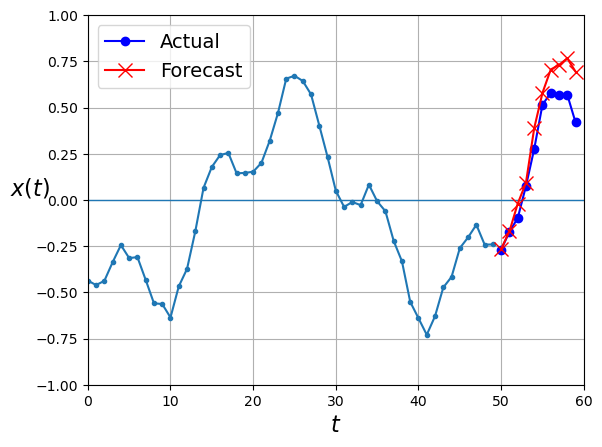

In [ ]:
Y_pred = model.predict(X_valid)
plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred[..., np.newaxis])

#### Model 1: Deep simple RNN with output prediction at the end

Let's create an RNN that predicts all 10 next values at once. To do that, all you need is to change the size of the final `Dense` layer to 10.

##### TODO: build and train the new RNN model with output size = 10
- Use two simple RNN layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)
- Use the Adam optimizer with the default learning rate
- Train it it for 20 epochs
- Don't forget to include your validation data
- Check the learning curves and the performance on the validation set

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

#TODO declare and train your model here

model = keras.Sequential([keras.layers.Input([None,1]),
                          keras.layers.SimpleRNN(units=20),
                          keras.layers.Dense(units=1)])

model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid))

In [ ]:
# saving model stats for later
pred_ten_models['DeepRNN_seq2vec']= {'model': model, 'history': history}

<Axes: >

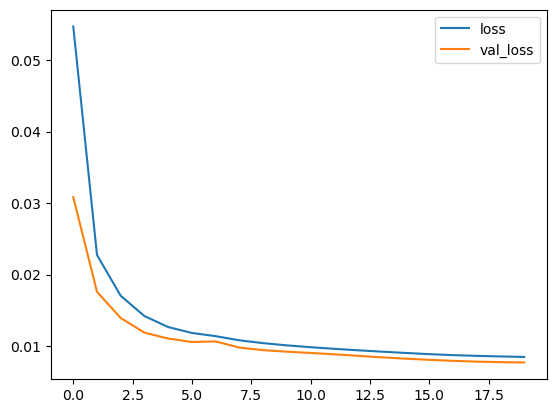

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077


0.007720244117081165

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


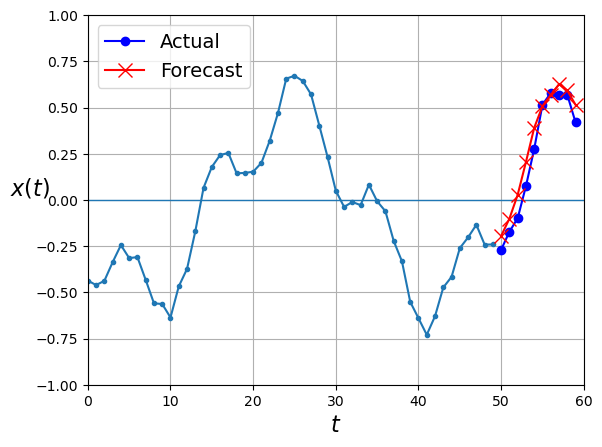

In [ ]:
Y_pred = model.predict(X_valid)
plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred[..., np.newaxis])

### Method 2B: Predicting 10 steps at once at every time step (seq2seq)

Now let's create RNN models that predict the next 10 steps at each time step.

This means that at t=0, the model predicts a vector with time steps t=1 to 1=10. Then as t=1, it predcits another vector with t=2 to t=11, and so on, until the end of the series.

A crucial difference here is that for each time step we expect a prediction, while before we only cared about the last output. This implies that the loss will contain a term for each time step, not just the last. This way, during backpropagation, each time-step will contribute with a gradient term flowing back, not only though time but also within the same time step. In practice, this is likely to stabilize AND speed-up training.


**Note:** In this model and all others used here, predictions for time $T$ only take into account past series values, i.e. where $t < T$. This defines them as a *causal* models.

#### Generating appropriate data and prediciton targets

For this method we'll "collect" more data, generating longer series with extra 10 steps.

We also need to generate the corresponting target array, which should contain 10-D vectors for all time steps $t>0$.

In [ ]:
np.random.seed(42)

n_steps = 50
# generate data with extra 10 steps
series = generate_time_series(10000, n_steps + 10)

# prep input arrays
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# generate target arrays using the last 10 steps
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

#### Custom evaluation metric function

All outputs are needed during training, but only the output at the last time step is useful at inference time for predictions and evaluation.
So even though we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to compute MSE only over the output at the last time step:

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mse(Y_true[:, -1], Y_pred[:, -1])

#### TODO Model 2: Deep simple RNN with output prediction at every timestep
- Use two simple RNN layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)
- Use the Adam optimizer with 0.01 learning rate
- Train it it for 20 epochs
- Don't forget to include your validation data
- Check the learning curves and the performance on the validation set

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

#TODO
model = keras.Sequential([keras.layers.Input([None,1]),
                          keras.layers.SimpleRNN(units=20),
                          keras.layers.Dense(units=1)])

model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0974 - val_loss: 0.0562
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0485 - val_loss: 0.0364
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0373 - val_loss: 0.0338
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0342 - val_loss: 0.0337
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0318 - val_loss: 0.0315
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0301 - val_loss: 0.0282
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0287 - val_loss: 0.0262
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0274 - val_loss: 0.0248
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0262 - val_loss: 0.0238
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0254 - val_loss: 0.0229
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0247 - val_loss: 0.0223
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [81]:
# saving model stats for later
pred_ten_models['DeepRNN_seq2seq']= {'model': model, 'history': history}

<Axes: >

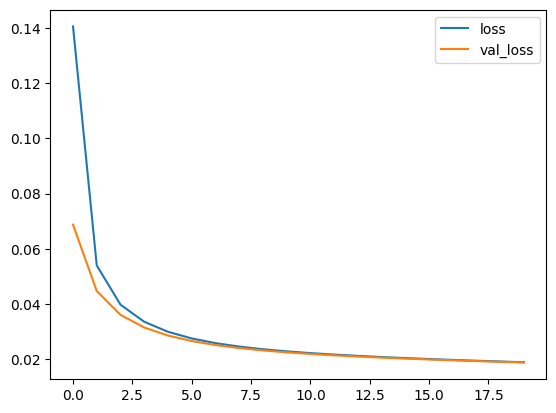

In [82]:
pd.DataFrame(history.history).plot()

In [83]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2042


0.20325596630573273

##### Plot multiple forecasts with the new shaped output




**Attention** Now we have outputs at every time steps, the shape of the array of predictions is different!

In [84]:
Y_pred = model.predict(X_valid)
X_valid.shape, Y_pred.shape, Y_valid.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


((2000, 50, 1), (2000, 1), (2000, 10))


You can reuse the previous function if you call it like this:
``` python
plot_multiple_forecasts(X_valid, Y_valid[:,-1,:, np.newaxis], Y_pred[:,-1,:, np.newaxis])
```


In [89]:
print(X_valid.shape)
print(Y_valid.shape)
print(Y_pred.shape)

(2000, 50, 1)
(2000, 10)
(2000, 1)


In [85]:
plot_multiple_forecasts(X_valid, Y_valid[:,-1,:, np.newaxis], Y_pred[:,-1,:, np.newaxis])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed


Or you can modify the function fot the new data shape. Here is an example.

In [ ]:
def plot_multiple_forecasts_seq(X, Y, Y_pred):
    # X should be a rank 3 array with shapes [batch size, sequence length, 1]
    # Y and y_pred should also be rank 3 with shape [0, sequence lenght, 1]
    n_steps = X.shape[1]
    ahead = Y.shape[-1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, -1, :], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, -1, :], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


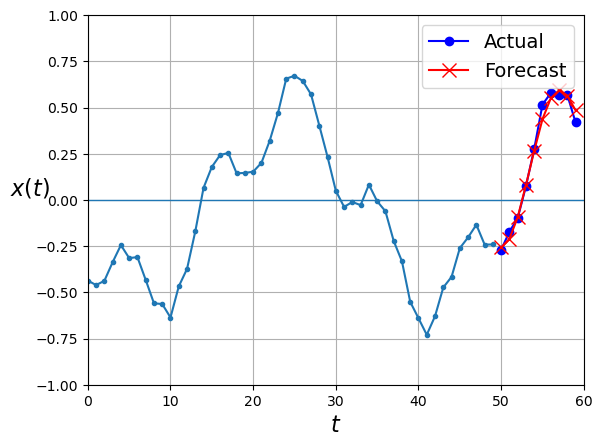

In [ ]:
plot_multiple_forecasts_seq(X_valid, Y_valid, Y_pred)

#### TODO Model 3: Deep LSTM with output prediction at every timestep

- Use two LSTM layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)
- Use the Adam optimizer with the default learning rate
- Train it it for 20 epochs
- Don't forget to include your validation data
- Check the learning curves and the performance on the validation set

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

#TODO

In [ ]:
# saving model stats for later
pred_ten_models['DeepRNN_LSTM']= {'model': model, 'history': history}

<Axes: >

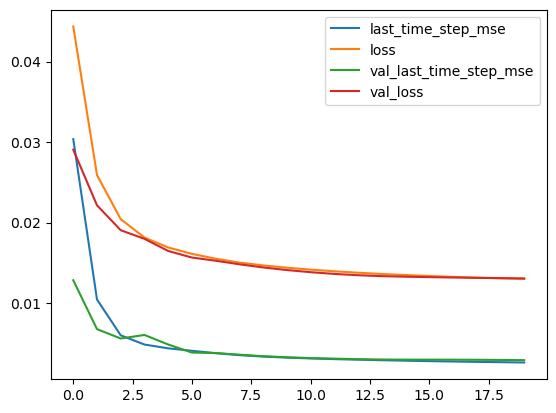

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - last_time_step_mse: 0.0029 - loss: 0.0131


[0.013059585355222225, 0.0029111227486282587]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


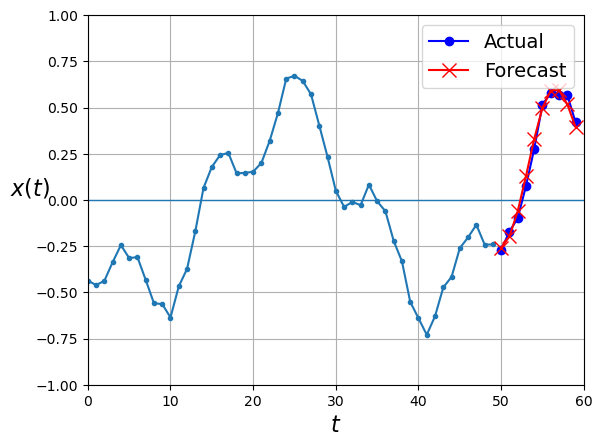

In [ ]:
Y_pred = model.predict(X_valid)
plot_multiple_forecasts(X_valid, Y_valid[:,-1,:, np.newaxis], Y_pred[:,-1,:, np.newaxis])

#### TODO Model 4: Deep GRU with output prediction at every timestep
- Use two GRU layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)
- Use the Adam optimizer with the default learning rate
- Train it it for 20 epochs
- Don't forget to include your validation data
- Check the learning curves and the performance on the validation set

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

#TODO

In [ ]:
# saving model stats for later
pred_ten_models['DeepRNN_GRU']= {'model': model, 'history': history}

<Axes: >

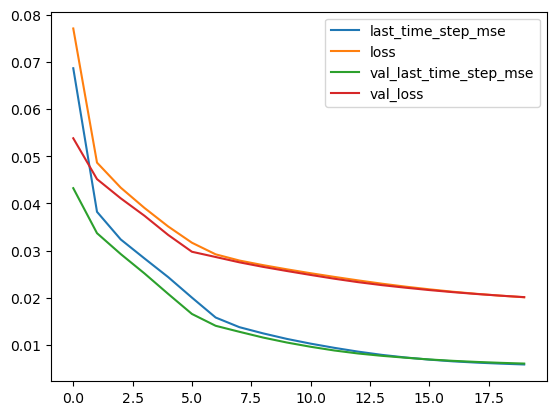

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - last_time_step_mse: 0.0060 - loss: 0.0201


[0.020138150081038475, 0.006062889471650124]

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


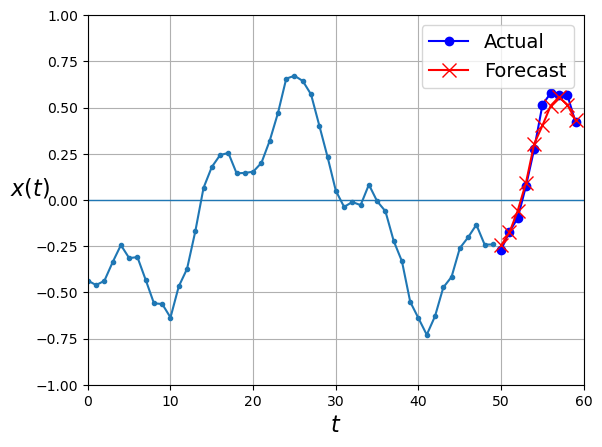

In [ ]:
Y_pred = model.predict(X_valid)
plot_multiple_forecasts(X_valid, Y_valid[:,-1,:, np.newaxis], Y_pred[:,-1,:, np.newaxis])

### TODO: Model comparison for prediction task 2

Create a summary table with the validation performaces of all models used in this second task. Choose the best of them and evaluate it on the test set. Did it generalize as well as predicted by the validation score?

In [ ]:
#TODO Complete with the best model
model = pred_ten_models[...]['model']
display(model.evaluate(X_test, Y_test))

Y_pred = model.predict(X_test)
plot_multiple_forecasts(X_test, Y_test[:,-1,:, np.newaxis], Y_pred[:,-1,:, np.newaxis])

## Extra models

Sequences can be treated with convolutional layers as we'll see in class soon. Here are two example models applied to the time series data we have used in this notebook.

#### Generating appropriate data and prediciton targets

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

#### Model 5: 1D convolution + GRUs
**Attention** Due to using a convolution stride of 2, the convolutional layer subsamples the input series by a factor of 2. That means that the predicted outputs will be related to the prediction targets with a similar subsampling factor.

Additionally, the kernel size of 4 in combination with using a valid convolution makes that the first predicted output corresponds to the 4th time-steps.

This means you should compare your predictions to a cropped and subsampled version of the targets array, as follows:
```
subsampled_target = target[:, 3::2]
```

##### TODO: train the conv + GRU model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set




In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

#TODO train the model

In [ ]:
# saving model stats for later
extra_models = {}
extra_models['DeepRNN_CNN']= {'model': model, 'history': history}

<Axes: >

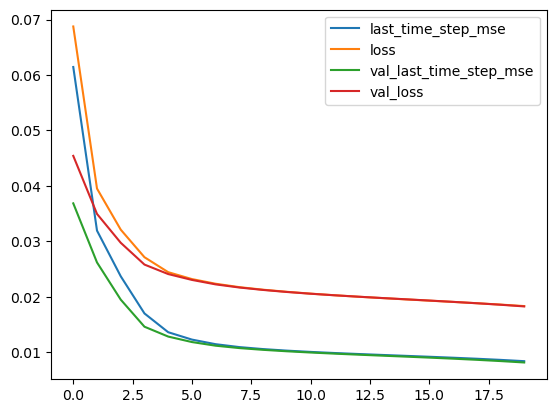

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - last_time_step_mse: 0.0082 - loss: 0.0184


[0.01828359253704548, 0.008176987059414387]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


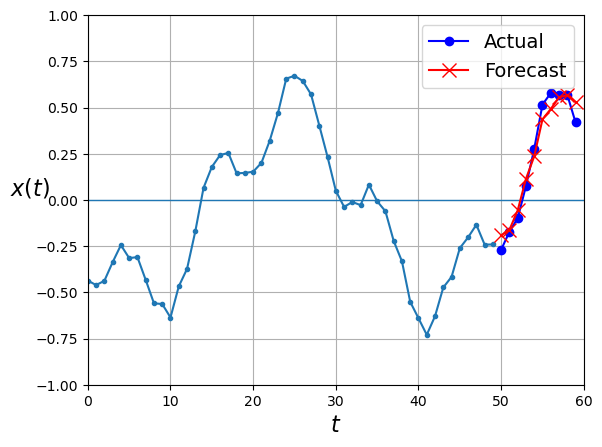

In [ ]:
Y_pred = model.predict(X_valid)
plot_multiple_forecasts_seq(X_valid, Y_valid[:, 3::2], Y_pred)

#### Model 6: WaveNet-like model
![Wavenet diagram](http://benanne.github.io/images/wavenet.png)
[From Oord et al., 2016](https://arxiv.org/abs/1609.03499)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.summary()

c:\Users\tdrumond\Miniconda3\envs\ml-latest\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, None, 20)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, None, 10)       │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,010 (23.48 KB)

 Trainable params: 6,010 (23.48 KB)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the WaveNet model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

In [ ]:
#TODO

In [ ]:
# saving model stats for later
extra_models['WaveNet']= {'model': model, 'history': history}

<Axes: >

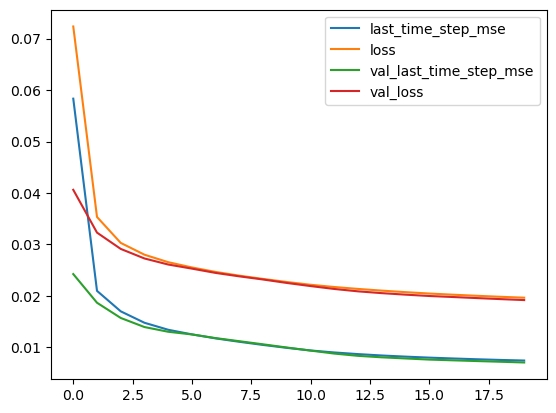

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - last_time_step_mse: 0.0072 - loss: 0.0191


[0.019201837480068207, 0.007079946808516979]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


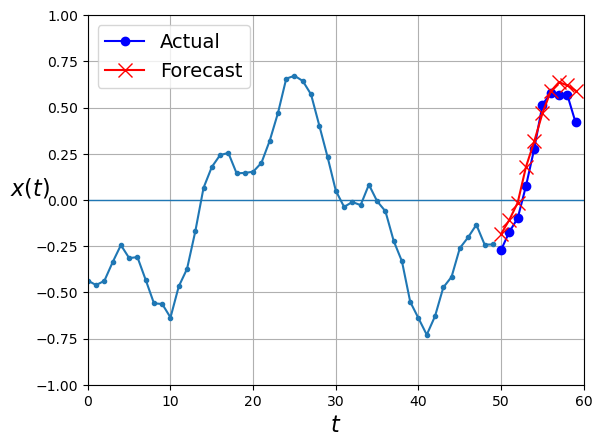

In [ ]:
Y_pred = model.predict(X_valid)
plot_multiple_forecasts_seq(X_valid, Y_valid, Y_pred)

#### Result summary wiht extra models